# Laboratorio 1
## Gasolina Diesel
### Data Science
### Series de timpo

Javier Ovalle, 
José Ángel Morales, 
Ricardo Morales

Link del repositorio: https://github.com/Saiyan-Javi/Lab2DS

Importamos todas las librerías a utilizar, tanto para la parte del lab 1 como para el lab 2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [5]:
#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [6]:

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
imp = pd.read_csv('IMPORTACIONES.csv', parse_dates=['Fecha'], index_col='Fecha', date_parser=dateparse)
print('\n Parsed Data:')
imp['Diesel'].head()

train_size = int(len(imp) * 0.6)
val_size = int(len(imp) * 0.2)

train_imp = imp[0:train_size]
val_imp = imp[train_size:train_size + val_size]
test_imp = imp[train_size + val_size:len(imp)]




 Parsed Data:


C:\Users\Javier Chiquin\AppData\Local\Temp\ipykernel_23392\344846036.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  imp = pd.read_csv('IMPORTACIONES.csv', parse_dates=['Fecha'], index_col='Fecha', date_parser=dateparse)


In [7]:
ts_imp_D = train_imp['Diesel']
ts_imp_D.tail(10)

Fecha
2014-10-01     762763.24
2014-11-01    1033873.16
2014-12-01    1004032.65
2015-01-01    1324421.96
2015-02-01     955286.02
2015-03-01    1164885.97
2015-04-01    1130870.79
2015-05-01     954782.75
2015-06-01     862071.77
2015-07-01    1149630.43
Name: Diesel, dtype: float64

### Modelo Arima


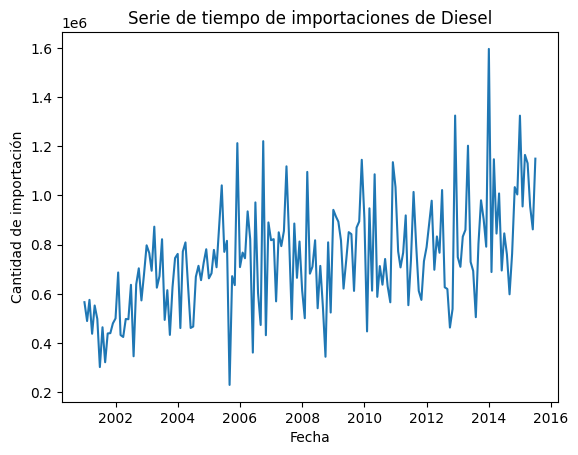

In [8]:
plt.plot(ts_imp_D)
plt.gca().set(title="Serie de tiempo de importaciones de Diesel", xlabel="Fecha", ylabel="Cantidad de importación")
plt.show()

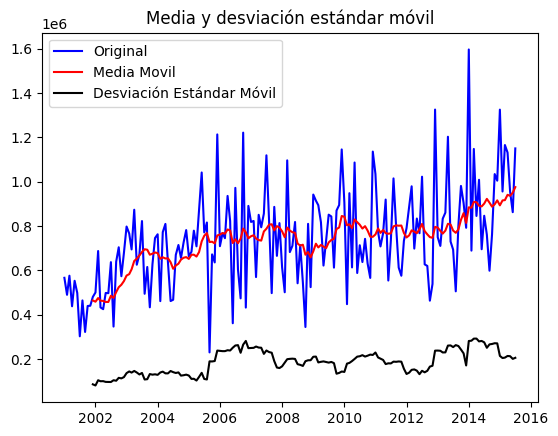

In [9]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = ts_imp_D.rolling(window=12).mean()
deMovil = ts_imp_D.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_D, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

Media móvil (rojo): Muestra claramente la tendencia creciente de las importaciones.

Desviación estándar móvil (negro): Indica que la variabilidad también aumenta con el tiempo, lo que es típico en series no estacionarias.

Serie original (azul): Se aprecian fluctuaciones y picos, pero la tendencia general es al alza.

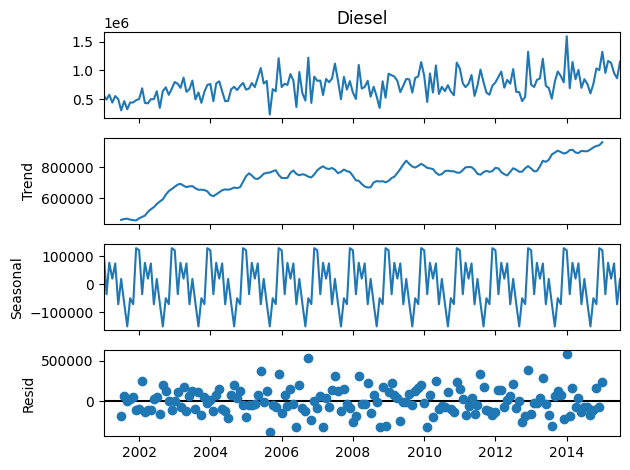

In [10]:
descomposicion = seasonal_decompose(ts_imp_D)
descomposicion.plot();

Tendencia: Se observa un crecimiento sostenido a lo largo de los años.

Estacionalidad: Hay un patrón estacional anual muy claro, con oscilaciones regulares cada año.

Residuales: Los residuos parecen estar centrados en cero, aunque con cierta variabilidad, lo que indica que la descomposición captura bien la tendencia y la estacionalidad.

## Estimar parámetros

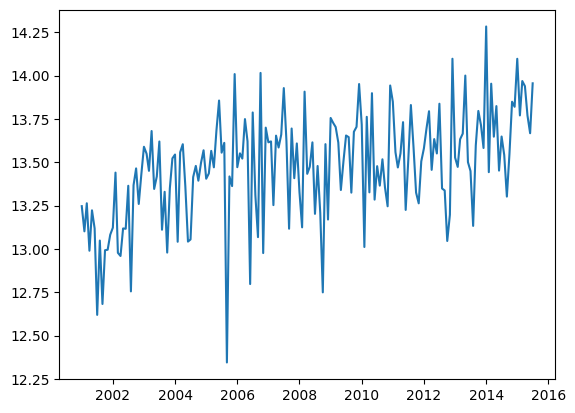

In [11]:
ts_imp_D_log = np.log(ts_imp_D)
plt.plot(ts_imp_D_log)

In [12]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_D, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.764567
p-value                        0.398190
# de retardos usados           9.000000
# de observaciones usadas    165.000000
Critical Value (1%)           -3.470616
Critical Value (5%)           -2.879221
Critical Value (10%)          -2.576197
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [13]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_D_diff = ts_imp_D.diff()
ts_imp_D_diff.dropna(inplace=True)
dfTest = adfuller(ts_imp_D_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.338280e+00
p-value                      1.081978e-10
# de retardos usados         1.000000e+01
# de observaciones usadas    1.630000e+02
Critical Value (1%)         -3.471119e+00
Critical Value (5%)         -2.879441e+00
Critical Value (10%)        -2.576314e+00
dtype: float64


El valor P es menor a 0.05, por lo que se puede rechazar la hipótesis nula y se puede decir que no hay raices unitarias.

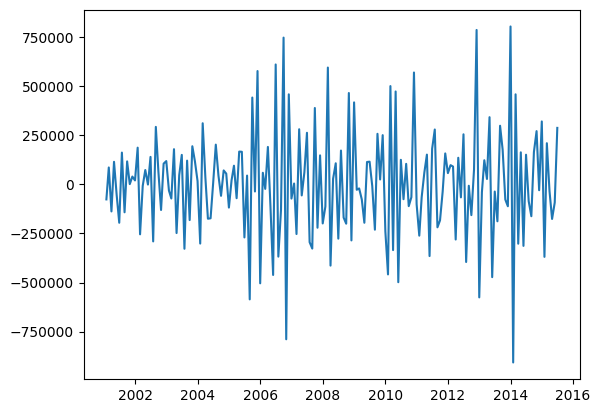

In [14]:
plt.plot(ts_imp_D_diff)

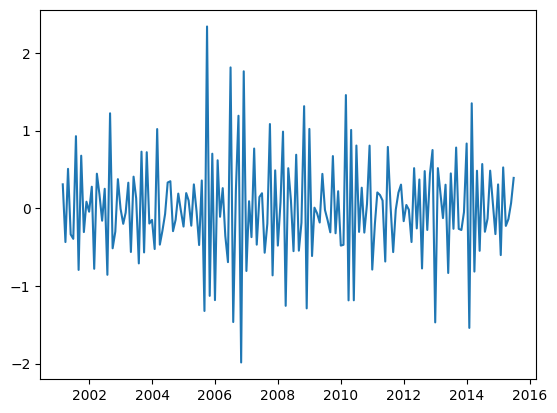

In [15]:
plt.plot(ts_imp_D_log.diff().diff())

Podemos decir que la serie es estacionaria ahora en media y en varianza. Toca ahora estimar los parámetros del modelo.

### Funciones de autocorrelación
#### Modelos teóricos


| Modelo    |                FAC                |                FACP               |
|-----------|:---------------------------------:|:---------------------------------:|
|   **MA(q)**   |         Se anula para j>q         | Decrecimiento rápido. No se anula |
|   **AR(p)**   | Decrecimiento rápido. No se anula |         Se anula para j>p         |
| **ARMA(p,q)** | Decrecimiento rápido. No se anula | Decrecimiento rápido. No se anula |  

In [16]:
ts_imp_D_log_diff = ts_imp_D_log.diff().diff()
ts_imp_D_log_diff.dropna(inplace = True)
tsa_acf = acf(ts_imp_D_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(ts_imp_D_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.71328884,  0.27136128, -0.0586159 , -0.06641789,
        0.15112594])

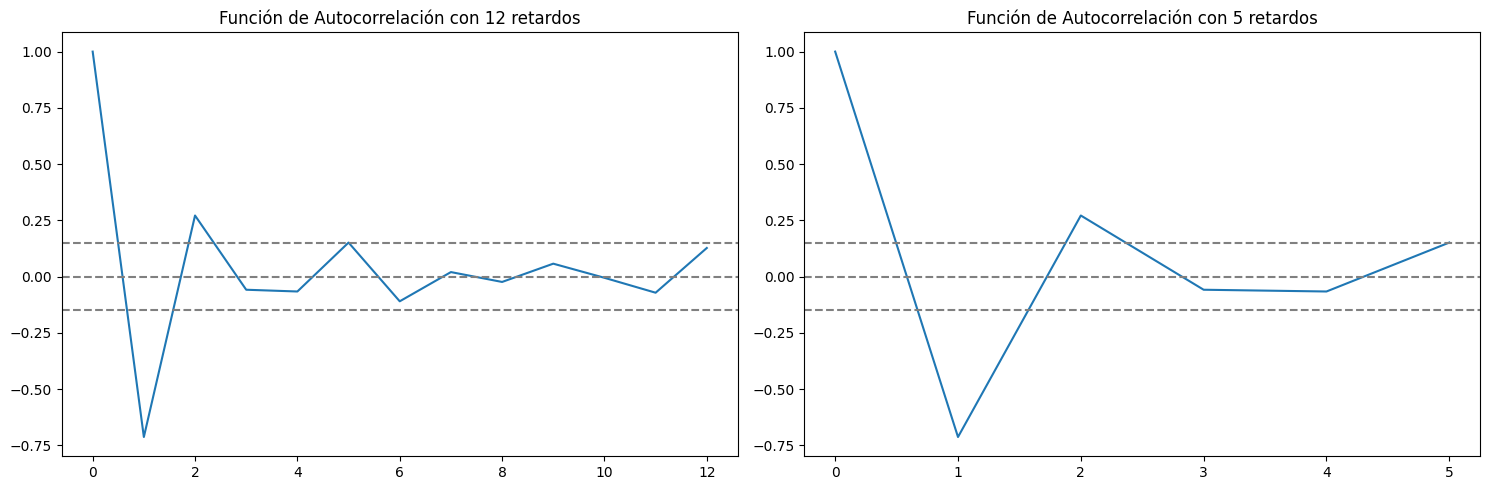

In [17]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_imp_D_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(ts_imp_D_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

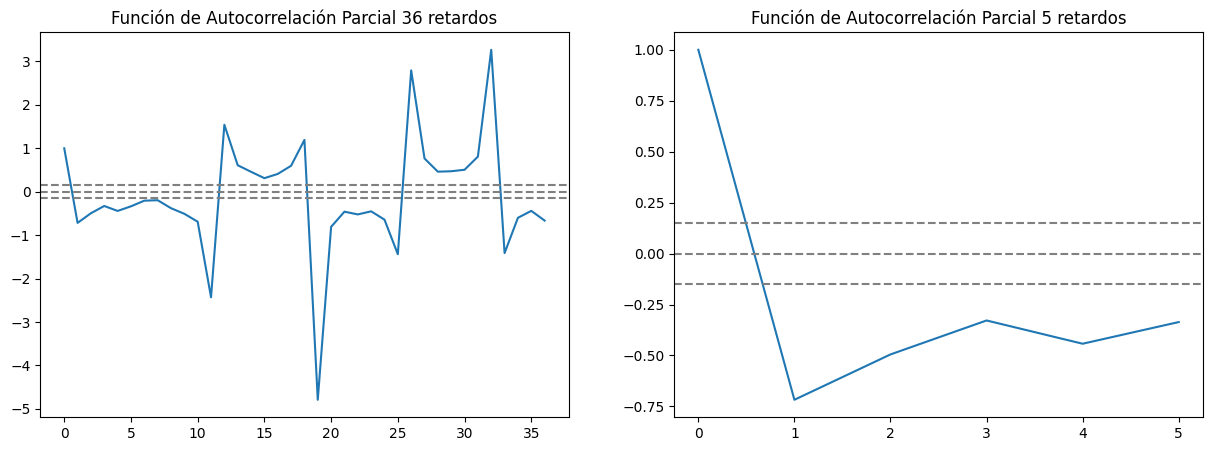

In [18]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_imp_D_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(ts_imp_D_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de las funciones de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA.
Podíamos probar varios modelos ARIMA:
- p=1, q=1
- p=2, q=1
  
En ambos casos solo es necesaria una diferenciación por lo que d=2

### Estacionalidad

Veamos ahora si hay estacionalidad en la serie. Hagamos un gráfico de la función de autocorrelación usando 36 resagos:

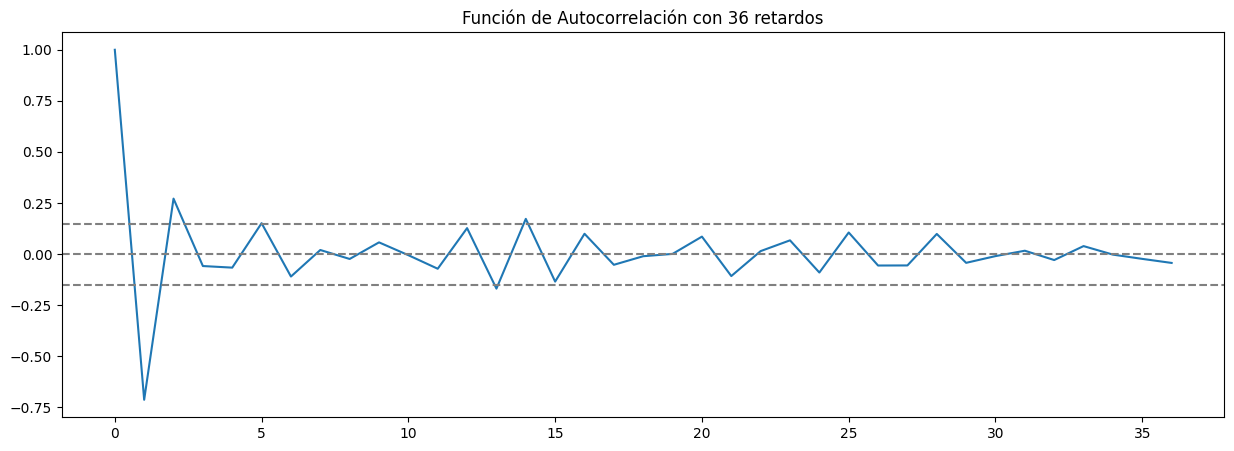

In [19]:
plt.plot(acf(ts_imp_D_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

La serie diferenciada no muestra autocorrelación significativa en los rezagos anuales, lo que sugiere que la estacionalidad fue eliminada o no es fuerte en la serie diferenciada.

In [20]:
ts_imp_D_log_D = ts_imp_D_log.diff(12)
ts_imp_D_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

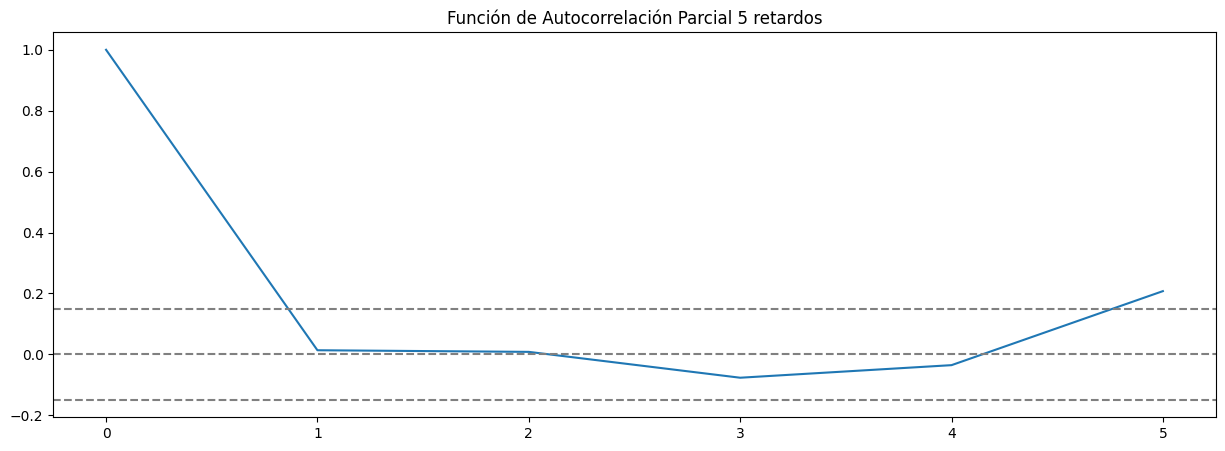

In [21]:
plt.plot(pacf(ts_imp_D_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

In [22]:
modelo121 = SARIMAX(ts_imp_D_log, order=(1,2,1), seasonal_order=(2,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m121 = modelo121.fit()
print(resultado_m121.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5974      0.073     -8.193      0.000      -0.740      -0.454
ma.L1         -1.0000    495.226     -0.002      0.998    -971.626     969.625
ar.S.L12      -0.7417      0.093     -7.989      0.000      -0.924      -0.560
ar.S.L24      -0.3723      0.096     -3.867      0.000      -0.561      -0.184
sigma2         0.1302     64.482      0.002      0.998    -126.253     126.513


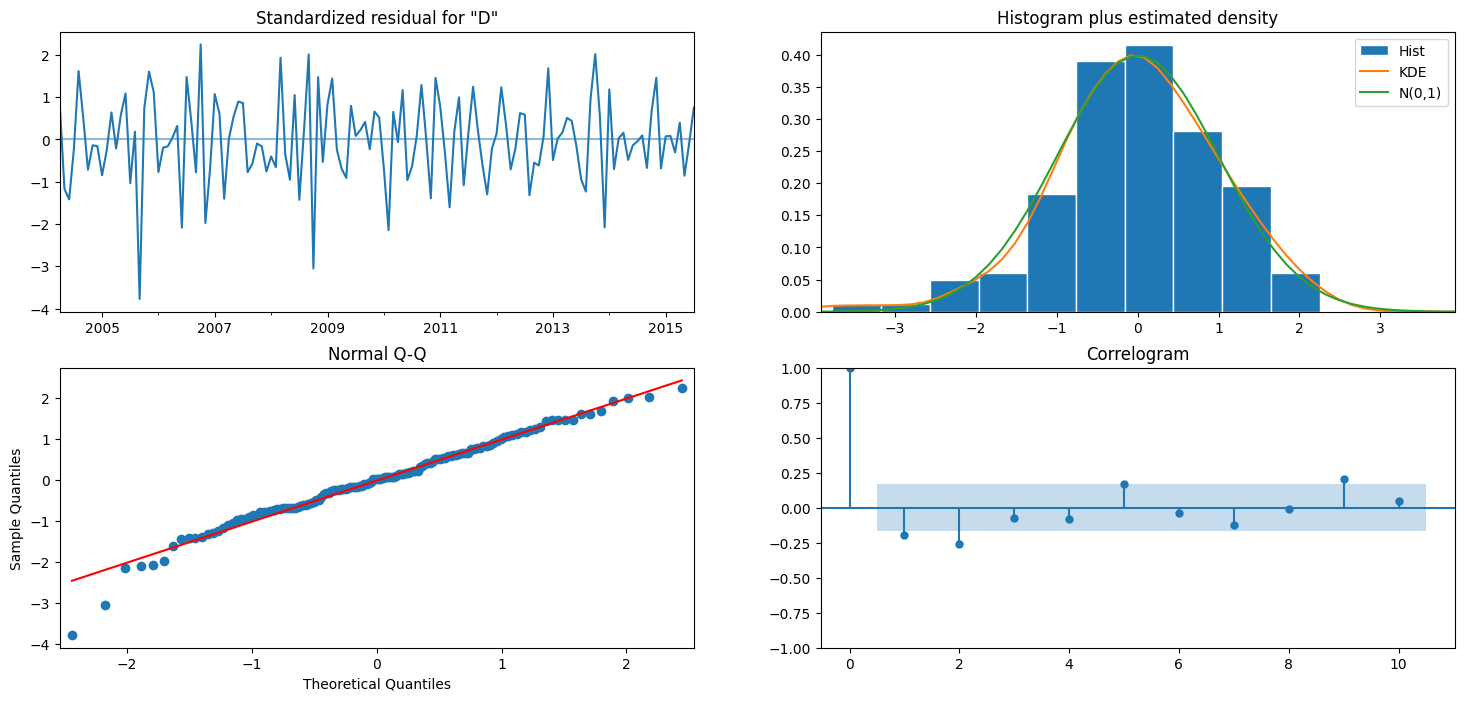

In [23]:
resultado_m121.plot_diagnostics(figsize=(18, 8))
plt.show()

 Como se puede obserevar los residuos presentan una distribución normal, y parecen comportarse como un ruido blanco dado que en el correlograma no hay autocorrelaciones significativas

In [24]:
modelo221 = SARIMAX(ts_imp_D_log, order=(2,2,1), seasonal_order=(2,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m221 = modelo221.fit()
print(resultado_m221.summary().tables[1])

c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8162      0.085     -9.581      0.000      -0.983      -0.649
ar.L2         -0.3167      0.073     -4.341      0.000      -0.460      -0.174
ma.L1         -1.0000    404.903     -0.002      0.998    -794.595     792.595
ar.S.L12      -0.8015      0.097     -8.288      0.000      -0.991      -0.612
ar.S.L24      -0.3524      0.095     -3.703      0.000      -0.539      -0.166
sigma2         0.1173     47.505      0.002      0.998     -92.990      93.225


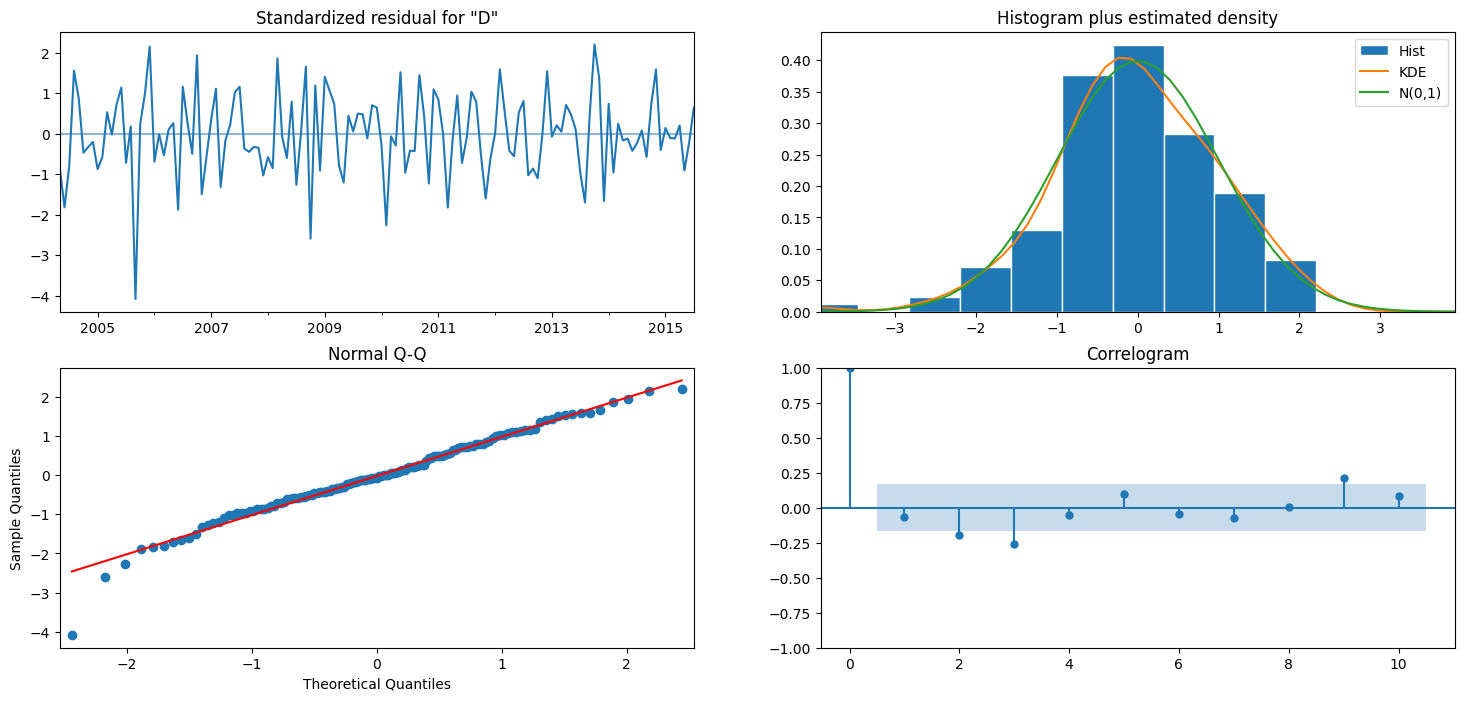

In [25]:
resultado_m221.plot_diagnostics(figsize=(18, 8))
plt.show()

En este otro modelo tampoco existen autocorrelaciones significativas y parecen estar distribuidos de forma normal

In [26]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 121=",resultado_m121.aic)
print("Modelo 221=",resultado_m221.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 121=",resultado_m121.bic)
print("Modelo 221=",resultado_m221.bic)

Resultados de AIC (Akaike information criterion)
Modelo 121= 123.37338633892195
Modelo 221= 110.2093044267049
Resultados de BIC (Bayesian information criterion)
Modelo 121= 137.9366607676022
Modelo 221= 127.64095309733548


## Predicción con el mejor modelo

In [27]:
test_imp.index[0]

Timestamp('2020-06-01 00:00:00')

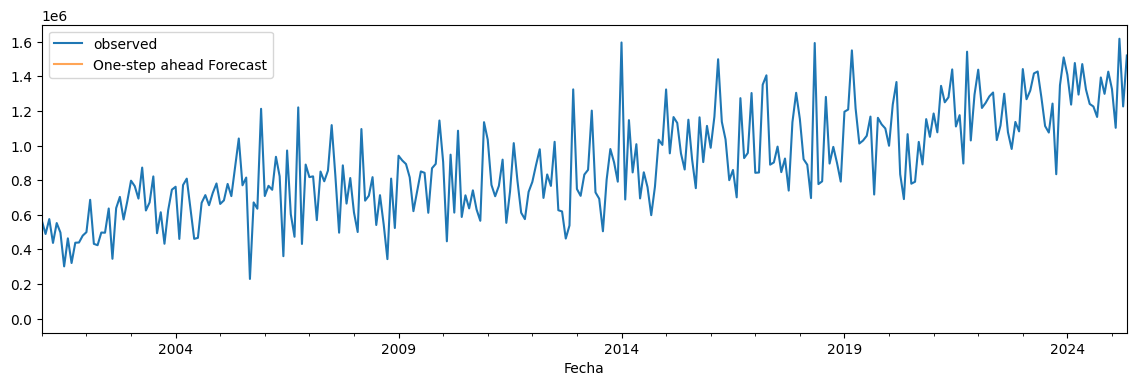

In [28]:
pred = resultado_m121.get_prediction(start=test_imp.index[0], dynamic=False)
pred_ci = pred.conf_int()
ax = imp['Diesel'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

pred

ARIMA - RMSE (prueba): 311811.43
ARIMA - MAE  (prueba): 272322.60
LSTM - RMSE (prueba): 257493.27
LSTM - MAE  (prueba): 222711.93

Comparación de modelos:
LSTM tiene un RMSE más bajo, lo que indica mejor rendimiento en términos de errores cuadrados.
LSTM tiene un MAE más bajo, lo que indica mejor rendimiento en términos de errores absolutos.


c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Javier Chiquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


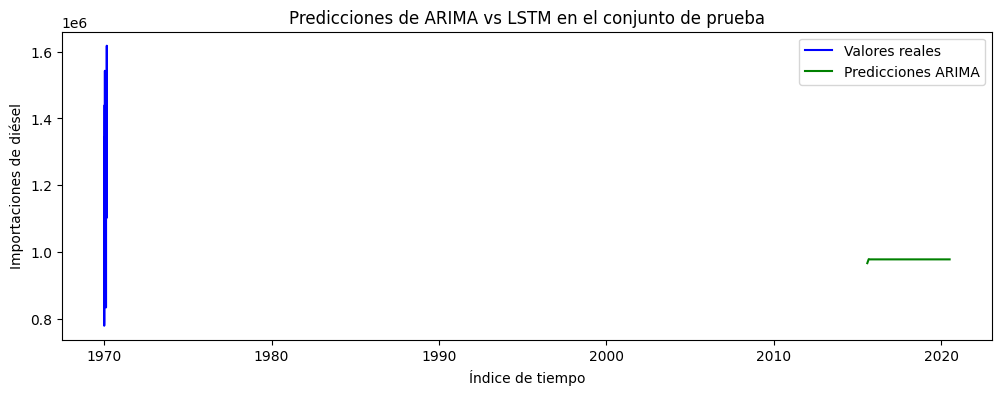

In [31]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

# Asegúrate de que 'imp' esté definido ejecutando la celda donde se carga el CSV antes de esta celda.
train_size = int(len(imp) * 0.6)
val_size = int(len(imp) * 0.2)

train_imp = imp[0:train_size]
val_imp = imp[train_size:train_size + val_size]
test_imp = imp[train_size + val_size:len(imp)]

y_train = train_imp['Diesel']
y_test = test_imp['Diesel']

# Ajustar el modelo ARIMA (ajusta el orden (p,d,q) según tu análisis, por ejemplo, usando gráficos ACF/PACF)
# Orden de ejemplo: (1,1,1) - es posible que necesites ajustarlo
arima_model = ARIMA(y_train, order=(1, 1, 1))
arima_result = arima_model.fit()

# Generar predicciones para el conjunto de prueba
# Pronosticar el mismo número de pasos que el conjunto de prueba
y_pred_arima = arima_result.forecast(steps=len(y_test))

# Asegurarse de que las predicciones y los datos de prueba estén alineados
y_test_inv = y_test.values  # Suponiendo que y_test_inv son los datos de prueba sin escalar (como en LSTM)
y_pred_arima_inv = y_pred_arima  # Si se usó escalado, invertir la transformación aquí

# Calcular RMSE y MAE para ARIMA
rmse_arima = np.sqrt(mean_squared_error(y_test_inv, y_pred_arima_inv))
mae_arima = mean_absolute_error(y_test_inv, y_pred_arima_inv)

# Métricas de LSTM del notebook
rmse_lstm = 257493.27
mae_lstm = 222711.93

# Imprimir comparación
print(f"ARIMA - RMSE (prueba): {rmse_arima:.2f}")
print(f"ARIMA - MAE  (prueba): {mae_arima:.2f}")
print(f"LSTM - RMSE (prueba): {rmse_lstm:.2f}")
print(f"LSTM - MAE  (prueba): {mae_lstm:.2f}")

# Determinar qué modelo tiene mejor rendimiento
print("\nComparación de modelos:")
if rmse_arima < rmse_lstm:
    print("ARIMA tiene un RMSE más bajo, lo que indica mejor rendimiento en términos de errores cuadrados.")
else:
    print("LSTM tiene un RMSE más bajo, lo que indica mejor rendimiento en términos de errores cuadrados.")

if mae_arima < mae_lstm:
    print("ARIMA tiene un MAE más bajo, lo que indica mejor rendimiento en términos de errores absolutos.")
else:
    print("LSTM tiene un MAE más bajo, lo que indica mejor rendimiento en términos de errores absolutos.")

# Visualizar predicciones
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv, label='Valores reales', color='blue')
plt.plot(y_pred_arima_inv, label='Predicciones ARIMA', color='green')
# plt.plot(y_pred_test_inv, label='Predicciones LSTM', color='red')  # y_pred_test_inv del notebook
plt.title('Predicciones de ARIMA vs LSTM en el conjunto de prueba')
plt.xlabel('Índice de tiempo')
plt.ylabel('Importaciones de diésel')
plt.legend()
plt.show()

# Aquí empieza el laboratorio 2

In [ ]:
tf.random.set_seed(123)
# Make sure the file name is correct and includes the extension, e.g., 'IMPORTACIONES.csv'
imp = pd.read_csv("IMPORTACIONES.csv", parse_dates=['Fecha'], index_col='Fecha')
print('\n Parsed Data:')
print(imp.head())

# ...existing code...
# Agrupa por año y suma los valores de cada columna
imp_anual = imp.resample('Y').sum()

# Si solo quieres ver la columna Diesel por año:
diesel_anual = imp['Diesel'].resample('Y').sum()

print(diesel_anual)
# ...existing code...



 Parsed Data:
            Aceites lubricantes  Asfalto      Bunker  Ceras  \
Fecha                                                         
2001-01-01                  0.0  27748.99  214581.84    0.0   
2001-02-01                  0.0   7503.57  294609.00    0.0   
2001-03-01                  0.0  26304.32  315263.80    0.0   
2001-04-01                  0.0   7885.89  205653.00    0.0   
2001-05-01                  0.0   8443.16  278371.30    0.0   

            Combustible turbo jet     Diesel  Diesel ultra bajo azufre  \
Fecha                                                                    
2001-01-01                    0.0  566101.99                       0.0   
2001-02-01                    0.0  489525.80                       0.0   
2001-03-01                    0.0  575559.68                       0.0   
2001-04-01                    0.0  437745.42                       0.0   
2001-05-01                    0.0  552609.13                       0.0   

            Gas licuado 

C:\Users\Javier Chiquin\AppData\Local\Temp\ipykernel_31192\694552765.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  imp_anual = imp.resample('Y').sum()
C:\Users\Javier Chiquin\AppData\Local\Temp\ipykernel_31192\694552765.py:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  diesel_anual = imp['Diesel'].resample('Y').sum()


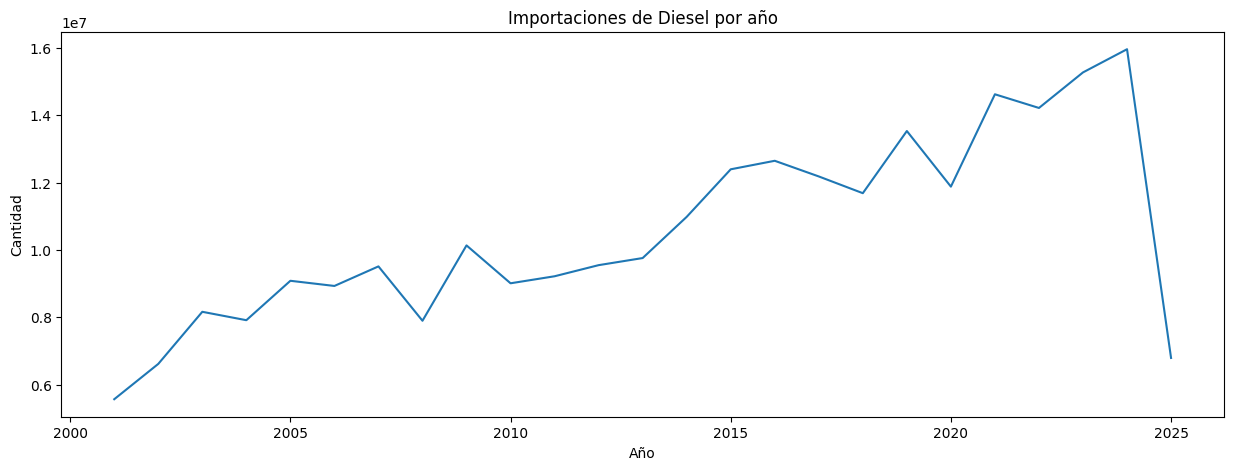

In [ ]:
plt.plot(diesel_anual.index.year, diesel_anual.values)
plt.gca().set(title="Importaciones de Diesel por año", xlabel="Año", ylabel="Cantidad")
plt.show()

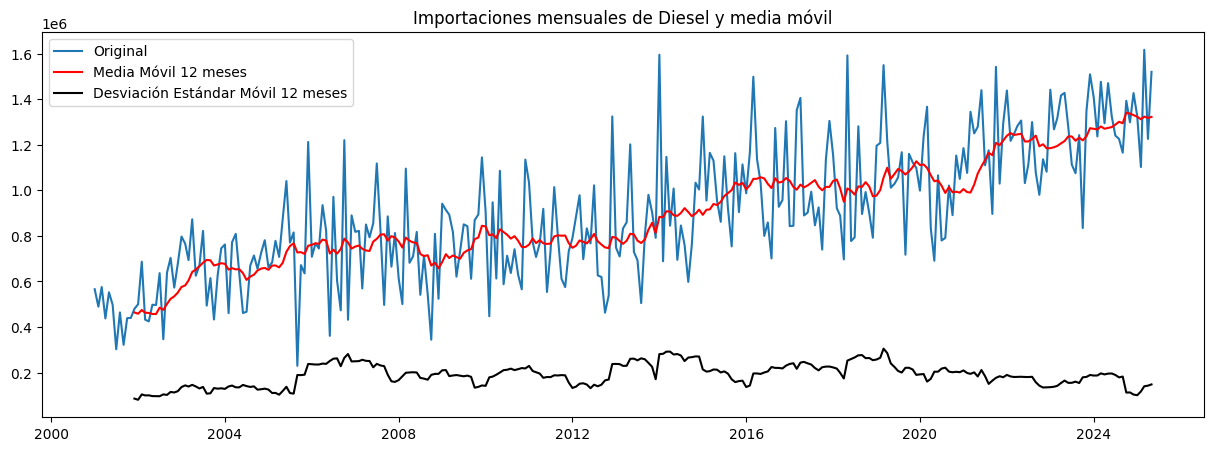

In [ ]:
# Descomposición estacional
mediaMovil = imp['Diesel'].rolling(window=12).mean()
deMovil = imp['Diesel'].rolling(window=12).std()
plt.plot(imp['Diesel'], label='Original')
plt.plot(mediaMovil, label='Media Móvil 12 meses', color='red')
plt.plot(deMovil, label='Desviación Estándar Móvil 12 meses', color='black')
plt.legend()
plt.title('Importaciones mensuales de Diesel y media móvil')
plt.show()


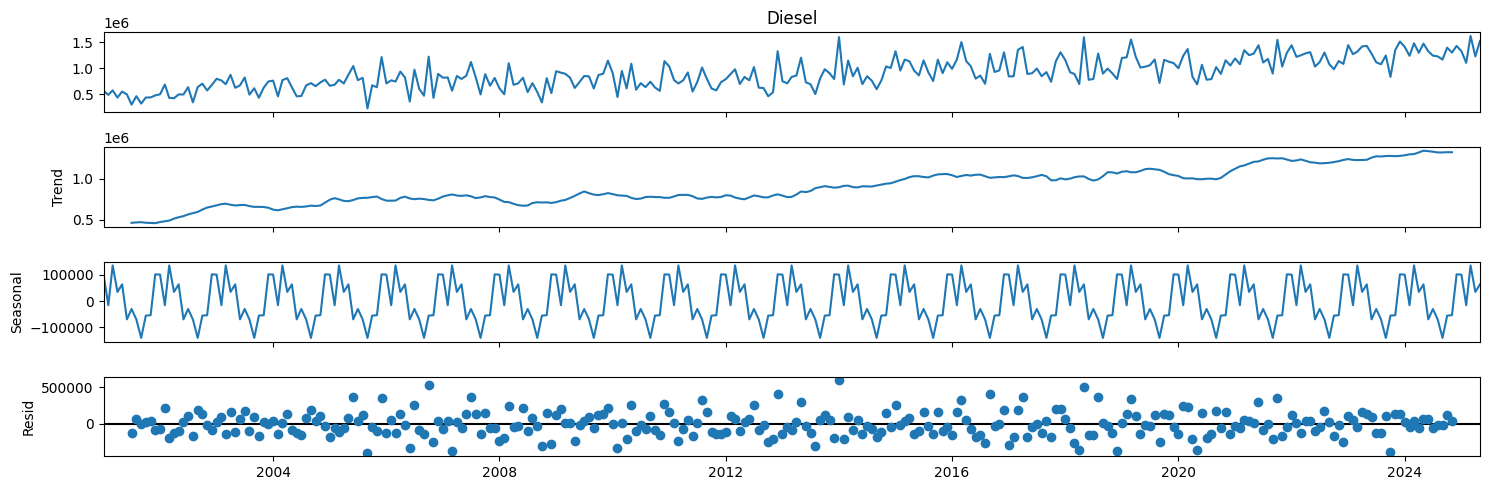

In [ ]:
# Descomposición estacional sobre la serie mensual de Diesel
descomposicion = seasonal_decompose(imp['Diesel'], model='additive', period=12)
descomposicion.plot()
plt.show()


Tendencia (Trend): Se observa una tendencia creciente a lo largo de los años, con algunos periodos de estabilidad y repuntes, lo que indica un aumento sostenido en las importaciones de Diesel.

Estacionalidad (Seasonal): Ahora sí se detecta un patrón estacional claro, con oscilaciones regulares cada año. Esto significa que hay meses en los que las importaciones tienden a subir o bajar de forma recurrente, probablemente por factores económicos, climáticos o de demanda.

Residuales (Resid): Los residuales muestran variabilidad alrededor de cero, lo que indica que el modelo de descomposición logra capturar bien la tendencia y la estacionalidad, aunque aún hay cierta variabilidad no explicada (ruido).

In [ ]:
print('Resultados del Test de Dickey Fuller')
dfTest_D = adfuller(imp['Diesel'], autolag='AIC')
salidaDf = pd.Series(dfTest_D[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest_D[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.788665
p-value                        0.822429
# de retardos usados          13.000000
# de observaciones usadas    279.000000
Critical Value (1%)           -3.454008
Critical Value (5%)           -2.871956
Critical Value (10%)          -2.572320
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [ ]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_D_diff = imp['Diesel'].diff()
ts_imp_D_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_D_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -9.223948e+00
p-value                      1.749540e-15
# de retardos usados         1.200000e+01
# de observaciones usadas    2.800000e+02
Critical Value (1%)         -3.453922e+00
Critical Value (5%)         -2.871918e+00
Critical Value (10%)        -2.572300e+00
dtype: float64


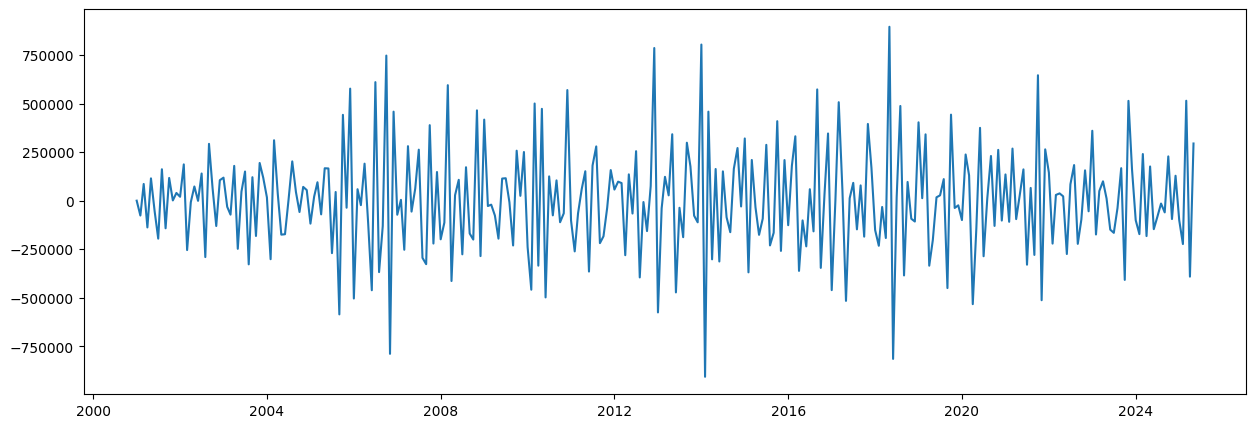

In [ ]:
plt.plot(ts_imp_D_diff)

In [ ]:
scaler = StandardScaler()
ts_imp_D_scaled = scaler.fit_transform(ts_imp_D_diff.values.reshape(-1, 1))
ts_imp_D_scaled[1:7]


array([[-0.29281567],
       [ 0.30360661],
       [-0.51742506],
       [ 0.40934885],
       [-0.21277562],
       [-0.72902441]])

In [ ]:
val_prueba = round(0.2*len(ts_imp_D_scaled))
val_prueba

59

In [ ]:
entrenamiento = round(0.6*len(ts_imp_D_scaled))
val_prueba = round(0.2*len(ts_imp_D_scaled))
test = ts_imp_D_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_imp_D_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_imp_D_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

59

In [ ]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [ ]:
print(train[0:6])
print(x_train[0:6])
print(y_train[0:6])


[[ 0.        ]
 [-0.01194902]
 [-0.29281567]
 [ 0.30360661]
 [-0.51742506]
 [ 0.40934885]]
[[ 0.        ]
 [-0.01194902]
 [-0.29281567]
 [ 0.30360661]
 [-0.51742506]
 [ 0.40934885]]
[-0.01194902 -0.29281567  0.30360661 -0.51742506  0.40934885 -0.21277562]


Creando el modelo

In [ ]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

In [ ]:
x_train

array([[[ 0.        ]],

       [[-0.01194902]],

       [[-0.29281567]],

       [[ 0.30360661]],

       [[-0.51742506]],

       [[ 0.40934885]],

       [[-0.21277562]],

       [[-0.72902441]],

       [[ 0.5815355 ]],

       [[-0.53353381]],

       [[ 0.41731863]],

       [[-0.00734298]],

       [[ 0.13380199]],

       [[ 0.06162003]],

       [[ 0.67349988]],

       [[-0.94498534]],

       [[-0.04081869]],

       [[ 0.25622009]],

       [[-0.01545192]],

       [[ 0.50118159]],

       [[-1.07745723]],

       [[ 1.06164811]],

       [[ 0.2257857 ]],

       [[-0.49045219]],

       [[ 0.37485838]],

       [[ 0.42303355]],

       [[-0.12723448]],

       [[-0.27592234]],

       [[ 0.64517809]],

       [[-0.921246  ]],

       [[ 0.15931096]],

       [[ 0.53870509]],

       [[-1.21472335]],

       [[ 0.43121939]],

       [[-0.67886147]],

       [[ 0.6999898 ]],

       [[ 0.42208124]],

       [[ 0.04989229]],

       [[-1.1175651 ]],

       [[ 1.12940181]],



### Creamos el modelo.   
#### Tensor Flow
Vamos a utilizar solo una capa LSTM 

In [ ]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

#Tensor Flow 2
#modelo1 = Sequential()
#modelo1.add(LSTM(lote,batch_input_shape=(lote,paso,caracteristicas),stateful=True))
#modelo1.add(Dense(1))
#modelo1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#early_stop = EarlyStopping(monitor='val_loss', patience=1)
modelo1.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])

In [ ]:
modelo1

<Functional name=functional_1, built=True>

In [ ]:
epocas = 150
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/150


176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5619 - root_mean_squared_error: 0.7196 - val_loss: 1.0700 - val_root_mean_squared_error: 1.0344
Epoch 2/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6043 - root_mean_squared_error: 0.7642 - val_loss: 1.0584 - val_root_mean_squared_error: 1.0288
Epoch 3/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5921 - root_mean_squared_error: 0.7558 - val_loss: 1.0587 - val_root_mean_squared_error: 1.0289
Epoch 4/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5838 - root_mean_squared_error: 0.7498 - val_loss: 1.0671 - val_root_mean_squared_error: 1.0330
Epoch 5/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5786 - root_mean_squared_error: 0.7461 - val_loss: 1.0774 - val_root_mean_squared_error: 1.0380
Epoch 6/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5774 - root_mean_squared_error: 0.7452 - val_loss: 1.0872 - val_root_mean_squared_error: 1.0427
Epoch 7/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

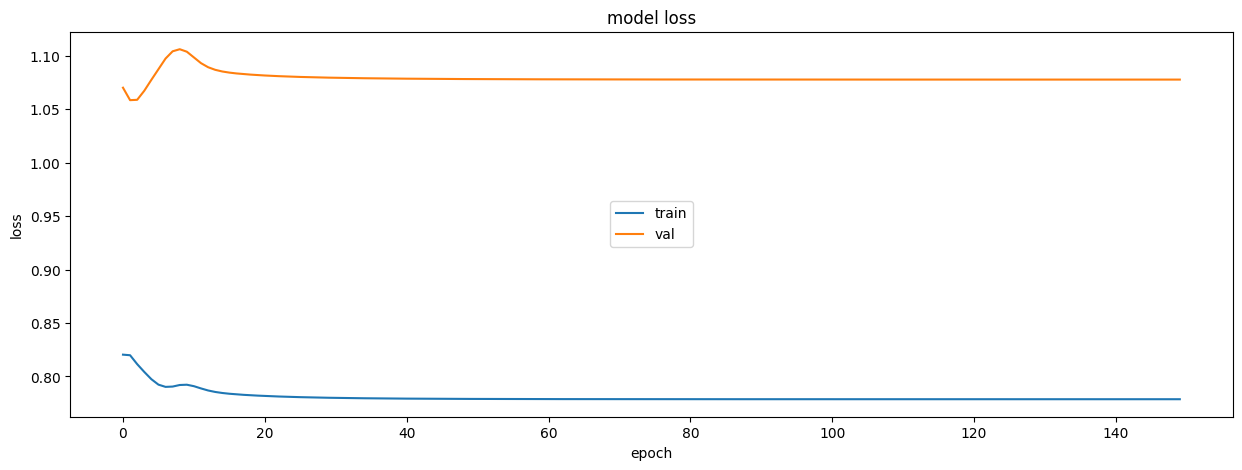

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

<Axes: >

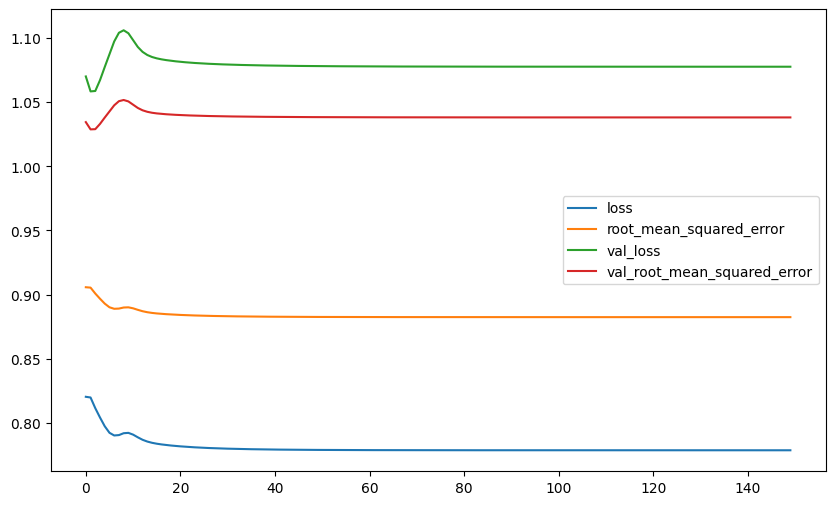

In [ ]:
losses_df1 = pd.DataFrame(history.history)

losses_df1.plot(figsize = (10,6))

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [ ]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6525 - root_mean_squared_error: 0.8012  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1198 - root_mean_squared_error: 1.0578
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5360 - root_mean_squared_error: 0.7313 


[0.5719056129455566, 0.756244421005249]

In [ ]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = imp['Diesel'].values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = imp['Diesel'].values , n=entrenamiento+val_prueba)


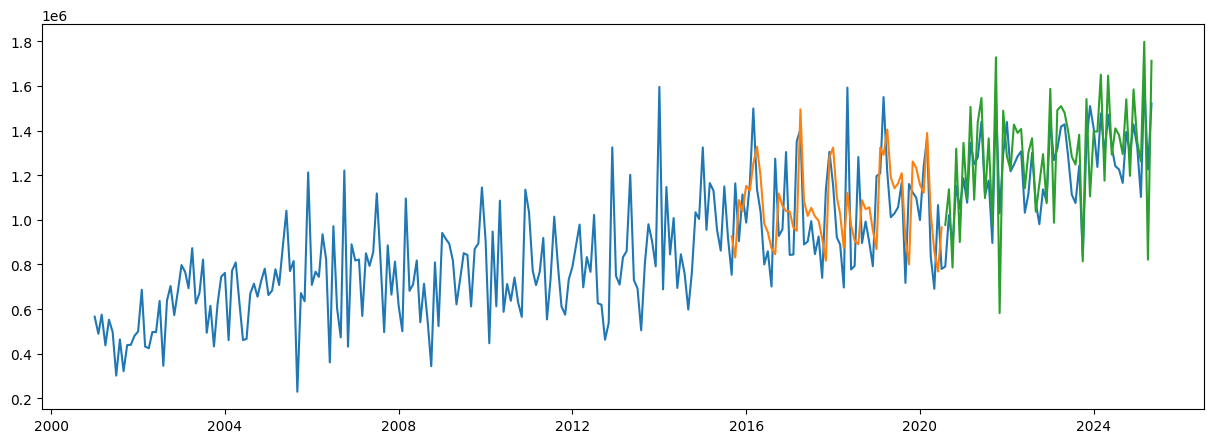

In [ ]:
df_val = pd.DataFrame(prediccion_val,index=imp['Diesel'][(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=imp['Diesel'][entrenamiento+len(df_val):len(imp['Diesel'])].index)


plt.plot(imp['Diesel'])
plt.plot(df_val)
plt.plot(df_test)

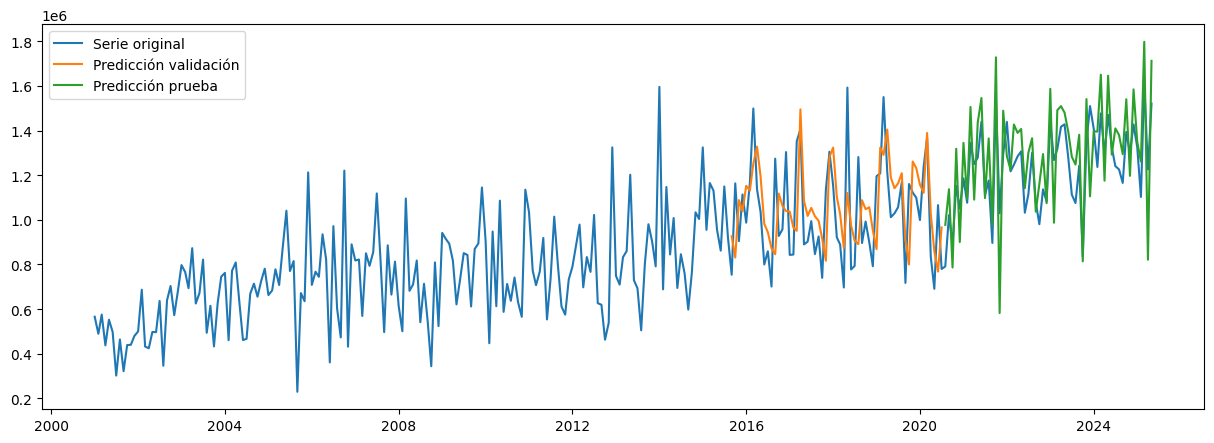

In [ ]:
plt.plot(imp['Diesel'], label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.show()

## Pytorch

Se define la clase que hereda de los modelos nn de pytorch para este modelo en específico

In [ ]:
class LSTMMiModelo(nn.Module):
    def __init__(self,input_size=1,hidden_size=20, num_layers = 1,output_size = 1 ):
        super().__init__()
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  
        self.hidden_size = hidden_size

    def forward(self,x):
        # x shape: (batch, seq_len, input_size)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)
SEQ_LENGTH = 12 #Por el ciclo estacional, una ventana de un año

# Después, rehace tus ventanas:
x_train, y_train = create_sequences(train, SEQ_LENGTH)
x_val, y_val     = create_sequences(validation, SEQ_LENGTH)
x_test, y_test   = create_sequences(test, SEQ_LENGTH)

In [ ]:
model = LSTMMiModelo()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Preparación de los datos
x_train_tensor = torch.from_numpy(x_train).float()        
y_train_tensor = torch.from_numpy(y_train).float()
x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Entrenamiento
En pytorch hay que hacer el entrenamiento "a mano" para tener el control del todo

In [ ]:

train_losses = []
val_losses = []
model.train()
running_train_loss = 0.0
for epoch in range(epocas):
    running_train_loss = 0.0  # Acumula la pérdida de la época
    for xb, yb in train_loader:  # Recorre cada batch
        outputs = model(xb)
        loss = loss_fn(outputs, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xb.size(0)
    
    # Calcula y muestra la pérdida promedio en el entrenamiento de la época
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) 

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = loss_fn(outputs, yb)
            running_val_loss += loss.item() * xb.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}, Loss promedio: {epoch_train_loss:.5f}")

Epoch 1, Loss promedio: 1.02518
Epoch 10, Loss promedio: 0.66539
Epoch 20, Loss promedio: 0.57995
Epoch 30, Loss promedio: 0.60270
Epoch 40, Loss promedio: 0.54427
Epoch 50, Loss promedio: 0.50497
Epoch 60, Loss promedio: 0.45906
Epoch 70, Loss promedio: 0.42912
Epoch 80, Loss promedio: 0.31150
Epoch 90, Loss promedio: 0.22112
Epoch 100, Loss promedio: 0.17323
Epoch 110, Loss promedio: 0.13746
Epoch 120, Loss promedio: 0.10100
Epoch 130, Loss promedio: 0.09198
Epoch 140, Loss promedio: 0.03814
Epoch 150, Loss promedio: 0.02602


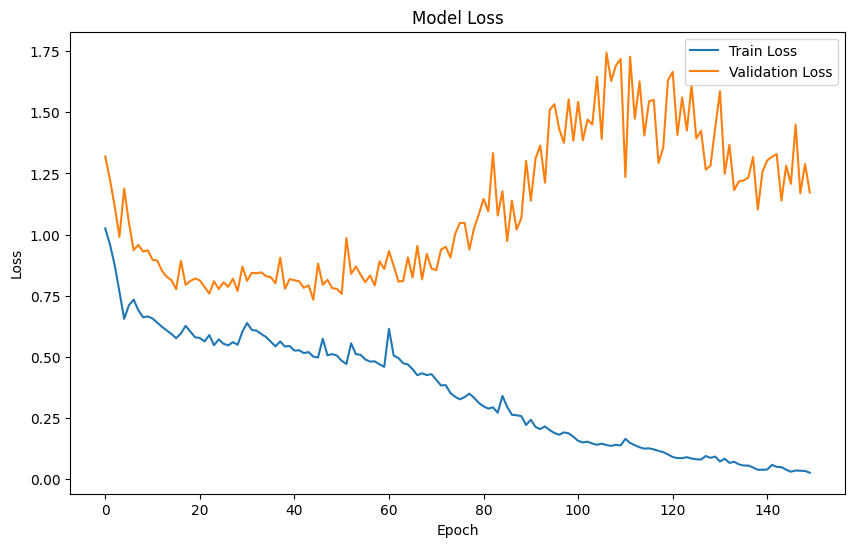

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()
model.eval()
with torch.no_grad():
    # Forma: (num_ejemplos, ventana, 1)
    y_pred_test = model(x_test_tensor)
    y_pred_test = y_pred_test.numpy()  # Convierte a numpy para graficar

In [ ]:
#Desnormalizar
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

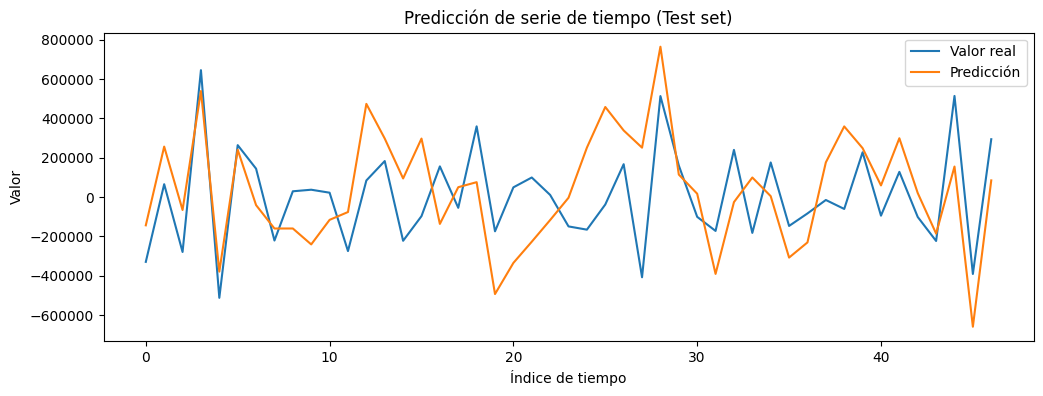

In [ ]:
# Graficar
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv, label='Valor real')
plt.plot(y_pred_test_inv, label='Predicción')
plt.title('Predicción de serie de tiempo (Test set)')
plt.xlabel('Índice de tiempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae_lstm = mean_absolute_error(y_test_inv, y_pred_test_inv)

print(f"LSTM - RMSE (test): {rmse_lstm:.2f}")
print(f"LSTM - MAE  (test): {mae_lstm:.2f}")

LSTM - RMSE (test): 257493.27
LSTM - MAE  (test): 222711.93


### Comparativa entre modelos

In [32]:
# Comparación de métricas entre ARIMA y LSTM
rmse_arima = 311811.43
mae_arima = 272322.60
rmse_lstm = 257493.27
mae_lstm = 222711.93

print(f"ARIMA - RMSE (prueba): {rmse_arima:.2f}")
print(f"ARIMA - MAE  (prueba): {mae_arima:.2f}")
print(f"LSTM - RMSE (prueba): {rmse_lstm:.2f}")
print(f"LSTM - MAE  (prueba): {mae_lstm:.2f}")

print("\nComparación de modelos:")
if rmse_arima < rmse_lstm:
    print("ARIMA tiene un RMSE más bajo, lo que indica mejor rendimiento en términos de errores cuadrados.")
else:
    print("LSTM tiene un RMSE más bajo, lo que indica mejor rendimiento en términos de errores cuadrados.")

if mae_arima < mae_lstm:
    print("ARIMA tiene un MAE más bajo, lo que indica mejor rendimiento en términos de errores absolutos.")
else:
    print("LSTM tiene un MAE más bajo, lo que indica mejor rendimiento en términos de errores absolutos.")

ARIMA - RMSE (prueba): 311811.43
ARIMA - MAE  (prueba): 272322.60
LSTM - RMSE (prueba): 257493.27
LSTM - MAE  (prueba): 222711.93

Comparación de modelos:
LSTM tiene un RMSE más bajo, lo que indica mejor rendimiento en términos de errores cuadrados.
LSTM tiene un MAE más bajo, lo que indica mejor rendimiento en términos de errores absolutos.
